# BRW Estimation

Replication code of the BRW shock by Bu, Wu, and Rogers (2021).

In [39]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from linearmodels.iv import IV2SLS
from bizdays import Calendar
from matplotlib.ticker import MaxNLocator

cal = Calendar.load("ANBIMA")
maturity = 2
year = 2020
month = 12
monthname = "Dec"
MAR2020 = 0

## 1. Calculating the difference of the 2-year Treasury series (DGS2)

Load the data and rename columns

In [2]:
data = pd.read_excel(r"C:\Users\Alysson\Documents\GitHub\Monetary-Shocks\Brasil\BRW\DGS2.xls")
data.rename(columns={"observation_date": "date"}, inplace=True)
data.sort_values(by='date', inplace=True)
data.replace(0, method='ffill', inplace=True)

Convert date to datetime format and create additional date-related columns

In [3]:
data["date"] = pd.to_datetime(data["date"])
data["year"] = data["date"].dt.year
data["month"] = data["date"].dt.month
data["day"] = data["date"].dt.day
data["mdate"] = data["date"].dt.to_period("M")

Filter data for the specified period (up to September 2019 - Cut-off date used for the estimation in the research paper.)

In [4]:
data = data[data["mdate"] <= pd.Period("2022-07")]
data = data[data["mdate"] >= pd.Period("1994-01")]

Calculate the difference of the series (dgs_d)

In [5]:
data["dgs_d"] = data["DGS" + str(maturity)] - data["DGS" + str(maturity)].shift(1)

Set "mdate" as the index and convert it to a time series

In [6]:
data.set_index("mdate", inplace=True)
data.index = pd.to_datetime(data.index.to_timestamp())

Drop unnecessary columns

In [7]:
data.drop(columns=["year", "month", "day"], inplace=True)
data.head()

,date,DGS2,dgs_d
mdate,,,
2000-04-01,2000-04-04,18.4837,NaN
2000-04-01,2000-04-05,18.7000,0.2163
2000-04-01,2000-04-06,18.8277,0.1277
2000-04-01,2000-04-07,18.6444,-0.1833
2000-04-01,2000-04-08,18.6444,0.0000


Save the resulting DataFrame to a new file

In [8]:
data.to_pickle("temp.pkl")

## 2. Adding COPOM dates

Load the COPOM dates from the Excel file

In [9]:
copom_dates = pd.read_excel("C:/Users/Alysson/Documents/GitHub/Monetary-Shocks/Brasil/BRW/COPOMdate.xlsx")
copom_dates.rename(columns={"date": "COPOM_date"}, inplace=True)

Convert date to datetime format and create additional date-related columns

In [10]:
dias_uteis = 1

copom_dates['COPOM_date'] = pd.to_datetime(copom_dates['COPOM_date'])
copom_dates = copom_dates[copom_dates['COPOM_date'] >= pd.Period("2001-01-01").to_timestamp()]
instrumento = pd.DataFrame({'COPOM_date': cal.offset(copom_dates['COPOM_date'],dias_uteis),'q':0})
copom_dates = pd.concat([copom_dates, instrumento])
copom_dates['COPOM_date'] = pd.to_datetime(copom_dates['COPOM_date'])
copom_dates["year"] = copom_dates["COPOM_date"].dt.year
copom_dates["month"] = copom_dates["COPOM_date"].dt.month
copom_dates["day"] = copom_dates["COPOM_date"].dt.day
copom_dates["mdate"] = copom_dates["COPOM_date"].dt.to_period("M")


Drop unnecessary columns

In [11]:
copom_dates.drop(columns=["year", "month", "day"], inplace=True)

Load the previous DataFrame "temp.dta" 

In [12]:
temp_data = pd.read_pickle("temp.pkl")

In [13]:
copom_dates

,COPOM_date,q,mdate
54,2001-01-17,1,2001-01
55,2001-02-14,1,2001-02
56,2001-03-21,1,2001-03
57,2001-04-18,1,2001-04
58,2001-05-23,1,2001-05
...,...,...,...
195,2022-10-27,0,2022-10
196,2022-12-08,0,2022-12
197,2023-02-02,0,2023-02
198,2023-03-23,0,2023-03


Merge the two DataFrames on the 'date' column

In [14]:
merged_data = pd.merge(temp_data, copom_dates, how="inner", left_on="date", right_on="COPOM_date")

Drop rows where 'q' is missing (denoted as NaN)

In [15]:
merged_data = merged_data.dropna(subset=["q"])

Replace missing values (NaN) in 'q' with 0

In [16]:
merged_data["q"].fillna(0, inplace=True)
merged_data.head()

,date,DGS2,dgs_d,COPOM_date,q,mdate
0,2001-01-17,16.0486,-0.1206,2001-01-17,1,2001-01
1,2001-01-18,15.9121,-0.1365,2001-01-18,0,2001-01
2,2001-02-14,15.8076,-0.0080,2001-02-14,1,2001-02
3,2001-02-15,15.9326,0.1250,2001-02-15,0,2001-02
4,2001-03-21,18.2104,0.5213,2001-03-21,1,2001-03


Save the merged DataFrame to a new file

In [17]:
merged_data.to_pickle("temp.pkl")

## 3. Estimation

Load the data from "svensson_br.xlsx" 

In [18]:
yield_data = pd.read_excel(r"C:\Users\Alysson\Documents\GitHub\Monetary-Shocks\Brasil\BRW\svensson_br.xlsx")

Convert 'date' column to datetime format and keeping only necessary columns

In [19]:
yield_data['date'] = pd.to_datetime(yield_data['Date'], format='%Y-%m-%d')
yield_data.sort_values(by='date', inplace=True)
yield_data.loc[:, 'SVENY01':'SVENY30'] = yield_data.loc[:, 'SVENY01':'SVENY30'].fillna(method='ffill')

In [20]:
yield_data['year'] = yield_data['date'].dt.year
yield_data['month'] = yield_data['date'].dt.month
yield_data['day'] = yield_data['date'].dt.day
yield_data['date'] = pd.to_datetime(yield_data[['year', 'month', 'day']])
yield_data['mdate'] = yield_data['date'].dt.to_period('M')
yield_data = yield_data[['date', 'mdate'] + [col for col in yield_data.columns if col.startswith('SVENY')]]
yield_data = yield_data[yield_data['mdate'] >= pd.Period('1994-01')]

In [24]:
yield_data.head()

,date,mdate,SVENY01,SVENY02,SVENY03,SVENY04,SVENY05,SVENY06,SVENY07,SVENY08,...,SVENY21_d,SVENY22_d,SVENY23_d,SVENY24_d,SVENY25_d,SVENY26_d,SVENY27_d,SVENY28_d,SVENY29_d,SVENY30_d
0,2006-01-02,2006-01,16.603599,16.069818,15.813602,15.678468,15.596889,15.542471,15.503599,15.474444,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2006-01-03,2006-01,16.594441,16.064808,15.800027,15.659489,15.574586,15.517946,15.477487,15.447142,...,-0.032460,-0.032604,-0.032736,-0.032857,-0.032968,-0.033071,-0.033166,-0.033254,-0.033336,-0.033412
2,2006-01-04,2006-01,16.567391,15.906773,15.597463,15.460412,15.396983,15.364394,15.345285,15.332609,...,-0.032320,-0.029997,-0.027877,-0.025933,-0.024145,-0.022494,-0.020965,-0.019546,-0.018225,-0.016991
3,2006-01-05,2006-01,16.564073,15.900342,15.579618,15.436914,15.374310,15.346010,15.332288,15.324890,...,0.021429,0.022280,0.023058,0.023771,0.024427,0.025032,0.025593,0.026113,0.026598,0.027050
4,2006-01-06,2006-01,16.537489,15.886892,15.571989,15.437172,15.385606,15.369317,15.366877,15.369324,...,0.093646,0.095058,0.096347,0.097529,0.098616,0.099620,0.100549,0.101412,0.102215,0.102965


Create a list for all maturities of the treasuries

Calculate differences for each maturity

In [22]:
list_maturities = [str(i).zfill(2) for i in range(1, 31)]

for num in list_maturities:
    col_name = f'SVENY{num}'
    yield_data[f'{col_name}_d'] = yield_data[col_name].diff()
selected_columns = yield_data.iloc[:, -30:]

Create aligned_dgs_d column

In [23]:
data_complete = merged_data.merge(yield_data, on=['date','mdate'], how='inner')
data_complete.head()

,date,DGS2,dgs_d,COPOM_date,q,mdate,SVENY01,SVENY02,SVENY03,SVENY04,...,SVENY21_d,SVENY22_d,SVENY23_d,SVENY24_d,SVENY25_d,SVENY26_d,SVENY27_d,SVENY28_d,SVENY29_d,SVENY30_d
0,2006-01-18,16.1660,-0.0851,2006-01-18,1,2006-01,16.168296,15.574431,15.318876,15.208869,...,0.019636,0.018121,0.016738,0.015471,0.014305,0.013229,0.012232,0.011307,0.010445,0.009641
1,2006-01-19,16.0114,-0.1546,2006-01-19,0,2006-01,16.009385,15.484445,15.271040,15.173919,...,-0.230086,-0.234513,-0.238557,-0.242266,-0.245679,-0.248830,-0.251747,-0.254456,-0.256979,-0.259333
2,2006-03-08,15.2753,0.1228,2006-03-08,1,2006-03,15.303771,14.930037,14.711954,14.572016,...,0.166905,0.166399,0.165938,0.165514,0.165125,0.164765,0.164433,0.164123,0.163836,0.163567
3,2006-03-09,15.1785,-0.0968,2006-03-09,0,2006-03,15.205391,14.847149,14.644118,14.517668,...,-0.009660,-0.009165,-0.008713,-0.008298,-0.007917,-0.007565,-0.007240,-0.006937,-0.006655,-0.006392
4,2006-04-19,14.6501,-0.0194,2006-04-19,1,2006-04,14.639425,14.616213,14.723955,14.805587,...,0.799602,0.821436,0.841429,0.859793,0.876714,0.892348,0.906836,0.920295,0.932831,0.944534


### Step 1 - 2SLS

In [25]:
### Creating IV

mask_q0 = data_complete["q"] == 0
mask_q1 = data_complete["q"] == 1
data_complete["const"] = 1
data_complete["iv"] = data_complete[mask_q1]["dgs_d"]
data_complete.loc[mask_q0, "iv"] = -1 * data_complete.loc[mask_q0, "dgs_d"]

In [26]:
for num in list_maturities:
    col_name = f'SVENY{num}_d'
    model = IV2SLS(dependent=data_complete[col_name], endog=data_complete["dgs_d"], exog=data_complete[["const"]], instruments=data_complete["iv"])
    results = model.fit()
    data_complete[f"beta_hat{num}"]=results.params["dgs_d"]
    print(results)
data_complete.head()

                          IV-2SLS Estimation Summary                          
Dep. Variable:              SVENY01_d   R-squared:                     -3.2162
Estimator:                    IV-2SLS   Adj. R-squared:                -3.2323
No. Observations:                 264   F-statistic:                    0.1507
Date:                Sat, Sep 16 2023   P-value (F-stat)                0.6979
Time:                        11:49:21   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const         -0.0158     0.0240    -0.6577     0.5107     -0.0629      0.0313
dgs_d         -1.0320     2.6587    -0.3882     0.69

                          IV-2SLS Estimation Summary                          
Dep. Variable:              SVENY13_d   R-squared:                     -1.7032
Estimator:                    IV-2SLS   Adj. R-squared:                -1.7136
No. Observations:                 264   F-statistic:                    0.7666
Date:                Sat, Sep 16 2023   P-value (F-stat)                0.3813
Time:                        11:49:21   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const          0.0226     0.0204     1.1063     0.2686     -0.0174      0.0626
dgs_d          1.7245     1.9696     0.8756     0.38

                          IV-2SLS Estimation Summary                          
Dep. Variable:              SVENY22_d   R-squared:                     -2.4698
Estimator:                    IV-2SLS   Adj. R-squared:                -2.4831
No. Observations:                 264   F-statistic:                    0.6441
Date:                Sat, Sep 16 2023   P-value (F-stat)                0.4222
Time:                        11:49:22   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const          0.0279     0.0262     1.0612     0.2886     -0.0236      0.0793
dgs_d          2.1033     2.6207     0.8026     0.42

,date,DGS2,dgs_d,COPOM_date,q,mdate,SVENY01,SVENY02,SVENY03,SVENY04,...,beta_hat21,beta_hat22,beta_hat23,beta_hat24,beta_hat25,beta_hat26,beta_hat27,beta_hat28,beta_hat29,beta_hat30
0,2006-01-18,16.1660,-0.0851,2006-01-18,1,2006-01,16.168296,15.574431,15.318876,15.208869,...,2.073979,2.10331,2.130319,2.155225,2.178232,2.199521,2.219257,2.237588,2.254645,2.270549
1,2006-01-19,16.0114,-0.1546,2006-01-19,0,2006-01,16.009385,15.484445,15.271040,15.173919,...,2.073979,2.10331,2.130319,2.155225,2.178232,2.199521,2.219257,2.237588,2.254645,2.270549
2,2006-03-08,15.2753,0.1228,2006-03-08,1,2006-03,15.303771,14.930037,14.711954,14.572016,...,2.073979,2.10331,2.130319,2.155225,2.178232,2.199521,2.219257,2.237588,2.254645,2.270549
3,2006-03-09,15.1785,-0.0968,2006-03-09,0,2006-03,15.205391,14.847149,14.644118,14.517668,...,2.073979,2.10331,2.130319,2.155225,2.178232,2.199521,2.219257,2.237588,2.254645,2.270549
4,2006-04-19,14.6501,-0.0194,2006-04-19,1,2006-04,14.639425,14.616213,14.723955,14.805587,...,2.073979,2.10331,2.130319,2.155225,2.178232,2.199521,2.219257,2.237588,2.254645,2.270549


### Step 2 - Fama and MacBeth

In [27]:
data_complete = data_complete.loc[~mask_q0]
maxt = len(data_complete)

aligned_dgs_d = []
for num in range(maxt):
    sveny_values = data_complete.iloc[num, data_complete.columns.get_loc("SVENY01_d"):data_complete.columns.get_loc("SVENY30_d") + 1].values.astype(float)
    beta_values = data_complete.iloc[num, data_complete.columns.get_loc("beta_hat01"):data_complete.columns.get_loc("beta_hat30") + 1].values.astype(float)

    # Adicionando uma constante à matriz independente (para o termo constante na regressão)
    X = sm.add_constant(beta_values)

    # Realizando a regressão usando o OLS do StatsModels
    model = sm.OLS(sveny_values, X)
    results = model.fit()

    # Imprimindo os coeficientes beta estimados
    aligned_dgs_d.append(results.params[1:])

data_complete["new_shock"]=aligned_dgs_d
data_complete["new_shock"] = data_complete["new_shock"].apply(lambda x: x[0])

In [28]:
data_complete

,date,DGS2,dgs_d,COPOM_date,q,mdate,SVENY01,SVENY02,SVENY03,SVENY04,...,beta_hat22,beta_hat23,beta_hat24,beta_hat25,beta_hat26,beta_hat27,beta_hat28,beta_hat29,beta_hat30,new_shock
0,2006-01-18,16.1660,-0.0851,2006-01-18,1,2006-01,16.168296,15.574431,15.318876,15.208869,...,2.10331,2.130319,2.155225,2.178232,2.199521,2.219257,2.237588,2.254645,2.270549,-0.024975
2,2006-03-08,15.2753,0.1228,2006-03-08,1,2006-03,15.303771,14.930037,14.711954,14.572016,...,2.10331,2.130319,2.155225,2.178232,2.199521,2.219257,2.237588,2.254645,2.270549,0.004742
4,2006-04-19,14.6501,-0.0194,2006-04-19,1,2006-04,14.639425,14.616213,14.723955,14.805587,...,2.10331,2.130319,2.155225,2.178232,2.199521,2.219257,2.237588,2.254645,2.270549,0.401269
6,2006-05-31,15.5581,0.2824,2006-05-31,1,2006-05,15.650954,16.233859,16.492478,16.647477,...,2.10331,2.130319,2.155225,2.178232,2.199521,2.219257,2.237588,2.254645,2.270549,-0.007320
8,2006-07-19,14.5308,-0.1601,2006-07-19,1,2006-07,14.561411,14.930508,15.213151,15.430707,...,2.10331,2.130319,2.155225,2.178232,2.199521,2.219257,2.237588,2.254645,2.270549,-0.053721
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
254,2021-12-08,11.3794,-0.1177,2021-12-08,1,2021-12,11.379499,11.088721,10.764404,10.654565,...,2.10331,2.130319,2.155225,2.178232,2.199521,2.219257,2.237588,2.254645,2.270549,0.021325
256,2022-02-02,12.1730,-0.0433,2022-02-02,1,2022-02,12.173050,11.476503,11.047817,10.931703,...,2.10331,2.130319,2.155225,2.178232,2.199521,2.219257,2.237588,2.254645,2.270549,-0.033357
258,2022-03-16,13.2593,0.0177,2022-03-16,1,2022-03,13.259328,12.892978,12.472667,12.290005,...,2.10331,2.130319,2.155225,2.178232,2.199521,2.219257,2.237588,2.254645,2.270549,0.031880
260,2022-05-04,13.0631,-0.0875,2022-05-04,1,2022-05,13.063135,12.496253,12.189923,12.112089,...,2.10331,2.130319,2.155225,2.178232,2.199521,2.219257,2.237588,2.254645,2.270549,0.040443


### Renormalization

In [29]:
renormalization = sm.OLS(data_complete["dgs_d"], data_complete["new_shock"])
results_renormalization = renormalization.fit()
beta_estimado = results_renormalization.params["new_shock"]
data_complete["BRW_daily"]=data_complete["new_shock"]*beta_estimado 
#print(results_renormalization.summary())


In [30]:
BRW_regression = sm.OLS(data_complete["dgs_d"], data_complete["BRW_daily"])
results_BRW_regression = BRW_regression.fit()
print(results_BRW_regression.summary())

                                 OLS Regression Results                                
Dep. Variable:                  dgs_d   R-squared (uncentered):                   0.000
Model:                            OLS   Adj. R-squared (uncentered):             -0.007
Method:                 Least Squares   F-statistic:                            0.03146
Date:                Sat, 16 Sep 2023   Prob (F-statistic):                       0.859
Time:                        11:49:37   Log-Likelihood:                          44.122
No. Observations:                 132   AIC:                                     -86.24
Df Residuals:                     131   BIC:                                     -83.36
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [40]:
# Definir a data de início e a data de término
start_date = pd.to_datetime("2006-01-01")
end_date = pd.to_datetime("2019-09-01")  # Especifique a data de término desejada

# Criar um intervalo de datas mensais até a data de término
date_range = pd.date_range(start=start_date, end=end_date, freq="M")

# Criar um DataFrame com a coluna de datas
data_monthly = pd.DataFrame({'mdate': date_range})

# Formatar as datas no estilo "1994-02"
data_monthly['mdate'] = data_monthly['mdate'].dt.strftime('%Y-%m')

columns = data_complete[['mdate', 'BRW_daily']]

columns['mdate'] = columns['mdate'].dt.strftime('%Y-%m')
data_monthly = data_monthly.merge(columns, on='mdate', how='left')
data_monthly['BRW_daily'].fillna(0, inplace=True)


# Imprimir as primeiras linhas do DataFrame
print(data_monthly)


       mdate  BRW_daily
0    2006-01   0.001015
1    2006-02   0.000000
2    2006-03  -0.000193
3    2006-04  -0.016313
4    2006-05   0.000298
..       ...        ...
159  2019-04   0.000000
160  2019-05  -0.000126
161  2019-06   0.001065
162  2019-07   0.000294
163  2019-08   0.000000

[164 rows x 2 columns]


C:\Users\Alysson\AppData\Local\Temp\ipykernel_12656\900990682.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  columns['mdate'] = columns['mdate'].dt.strftime('%Y-%m')


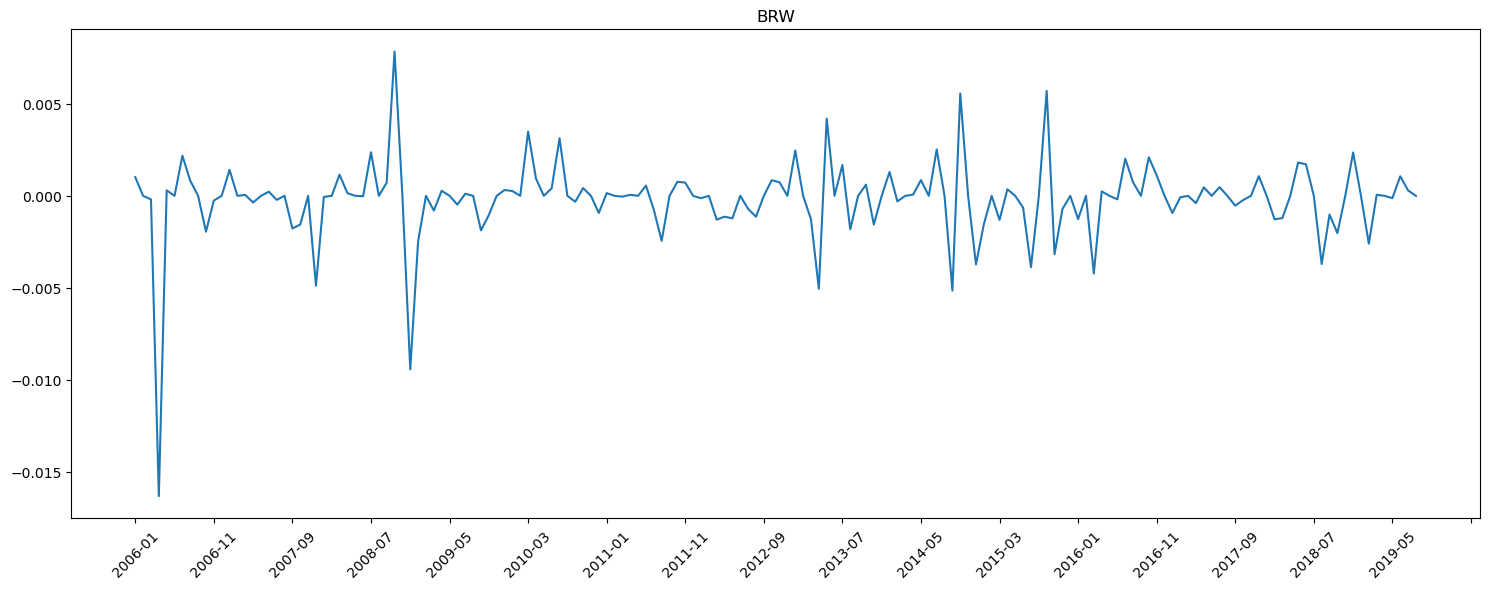

In [42]:
# Converter valores do tipo Period para datetime
mdate_values = data_monthly["mdate"]
new_shock_values = data_monthly["BRW_daily"]

# Criar um gráfico de linha
plt.figure(figsize=(15, 6))
plt.plot(mdate_values, new_shock_values)
plt.title("BRW")
ax = plt.gca()
ax.xaxis.set_major_locator(MaxNLocator(nbins=20))
plt.xticks(rotation=45)
plt.grid(False)
plt.tight_layout()
plt.show()

In [ ]:
subset_data = data_monthly

# Especifique o nome do arquivo Excel de saída
output_file = "data_subset.xlsx"

# Salve o DataFrame no arquivo Excel
subset_data.to_excel(output_file, index=False)